# Analyzing Flu Related Reddit comments

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from datetime import datetime, timedelta
from glob import glob
from pprint import pprint
%matplotlib inline

# convert to 0-1 range using min-max normalization
def normalizeDf(df):
    return ( df - df. min() ) / (df.max() - df.min() )

# convert epiweek (e.g. 200801) --> datetime
def epiweekToDatetime(epiweek):
    epiweek = str(epiweek)
    return datetime.strptime(epiweek + '6', "%Y%W%w") - timedelta(days=6)

In [132]:
comments = pd.read_csv('/home/william/wikidemics/data/reddit/all.csv')
comments['created_utc'] = pd.to_datetime(comments.loc[:, 'created_utc'], unit='s')
comments.set_index('created_utc', inplace=True)
comments = comments.sort_index()
comments[:3]

,body,subreddit,score
created_utc,,,
2006-01-05 21:03:24,companies that raise chickens said Thursday th...,reddit.com,1
2006-02-07 18:07:26,"The article says: ""In the first place, it woul...",reddit.com,1
2006-03-05 20:28:55,(I've caught the flu and probably shouldn't wa...,reddit.com,5


## Graphing 

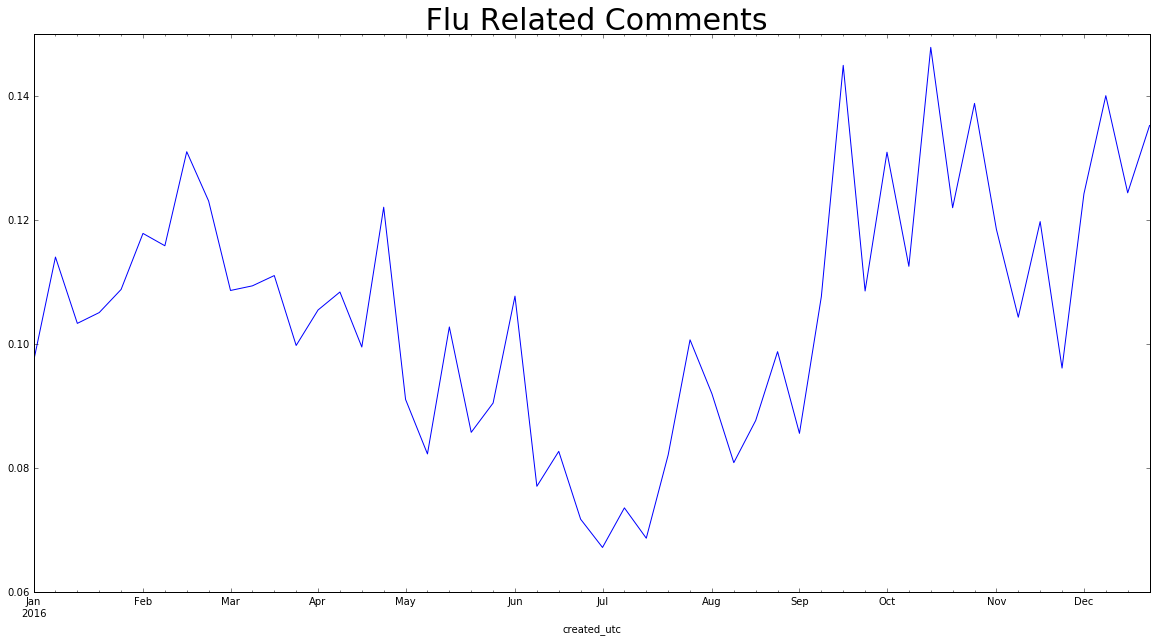

In [201]:
# count total comments for each year 
yearly_totals_df = comments.resample('A').size()
yearly_totals = {dt.year:yearly_totals_df.loc[dt] for dt in yearly_totals_df.index}

# normalize the data, represent # of comments as proportion to that years total
weekly_comment_counts = comments.resample('W').size().astype('float64')
for week in weekly_comment_counts.index:
    weekly_comment_counts[week] /= yearly_totals[week.year]
    
weekly_comment_counts = normalizeDf(weekly_comment_counts)

# plot the normalized weekly comment counts between start and end date
startdt, enddt = datetime(2016,1,1), datetime(2016,12,31)
date_mask = ((weekly_comment_counts.index > startdt) & 
            (weekly_comment_counts.index <= enddt))
weekly_comment_counts[date_mask].plot(figsize=[20,10])
plt.title(' Flu Related Comments', fontsize=30)

In [202]:
%store -r wILI
%store -r epiweeksDf
epiweekly_comment_counts = pd.DataFrame(columns=['Count'])
for year in range(2008, 2017):
        for epiweek_num, epiweek_start in enumerate(epiweeksDf[year]):
            if epiweek_start == 0:
                continue
            epiweek_end = epiweek_start +  timedelta(days=6, hours=23)
            mask = ((comments.index >= epiweek_start) & 
                    (comments.index <= epiweek_end))
            # aggregate on epiweeks
            weekly_comments_total = comments[mask].shape[0]
            # pad epiweek_num w/ 0 if value is < 10
            epiweek_num = str(epiweek_num) if epiweek_num >= 10 else '0' + str(epiweek_num)
            epiweek_with_year = int(str(year) + epiweek_num) + 1
            epiweekly_comment_counts.loc[epiweek_with_year] = weekly_comments_total
# normalize the counts, represent # of comments as proportion to that years total
for epiweek in epiweekly_comment_counts.index:
    epiweekly_comment_counts.loc[epiweek]['Count'] /= yearly_totals[int(str(epiweek)[:4])]
#epiweekly_comment_counts = normalizeDf(epiweekly_comment_counts)

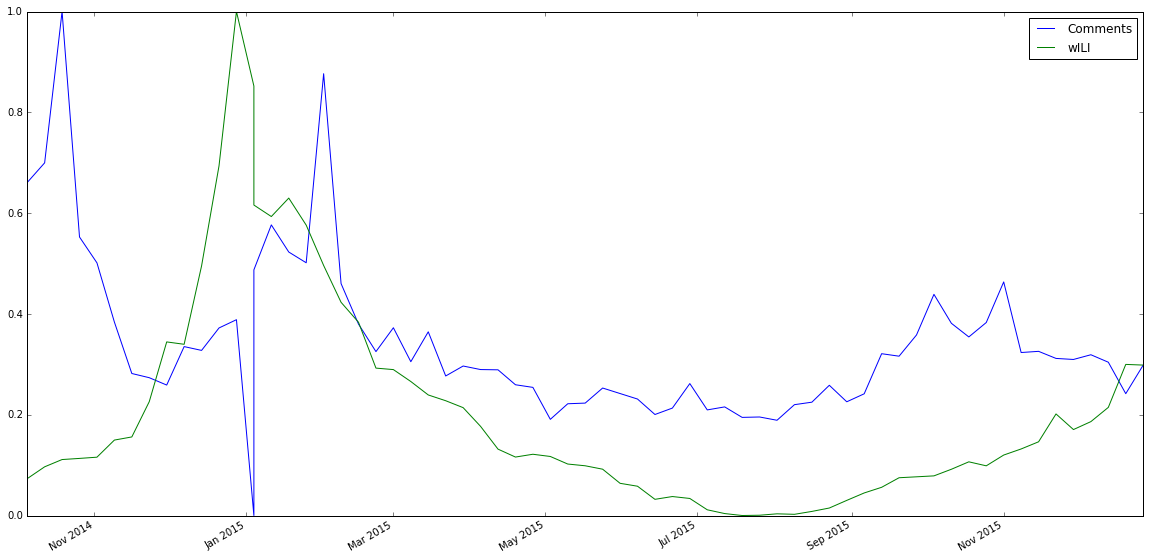

In [203]:
#### plot the normalized weekly comment counts between start and end date
start, end = 201440, 201552
plot_df = pd.DataFrame({'Comments':epiweekly_comment_counts.loc[start:end, 'Count'],
                        'wILI': wILI.loc[start:end, 'Weekly ILI']},
                       index=wILI.loc[start:end].index)
plot_df = normalizeDf(plot_df)
plot_df.index = list( map(epiweekToDatetime, plot_df.index) )
plot_df.plot(figsize=[20,10])

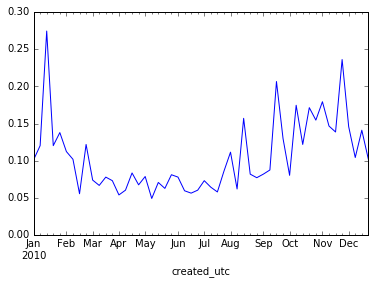

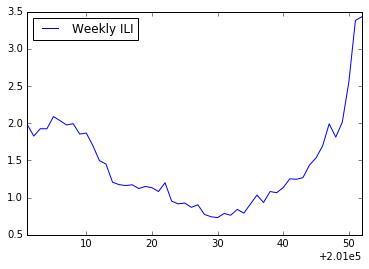

In [234]:
yr = 2010
s, e = datetime(yr, 1, 1), datetime(yr, 12, 31)
weekly_comment_counts[s:e].plot()

s, e = int(str(yr) + '01'), int(str(yr) + '52')
wILI.loc[s:e].plot()